In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

C:\ProgramData\Anaconda3\envs\tensorflow35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Hardcode all variables
predict_batch_size_exp = 1
epoch_exp = 200
neurons_exp = 5
predict_values_exp = 24
lag_exp=24

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
# fit an LSTM network to training data

from keras.layers import Activation, Dense, BatchNormalization, TimeDistributed

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_exp, dropout = 0.1 ,batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
# make a one-step forecast with new model with batch size 1
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    # re-define model
    new_model = Sequential()
    new_model.add(LSTM(neurons_exp, dropout = 0.1 , batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    new_model.add(BatchNormalization())
    new_model.add(Dense(50))
    new_model.add(Activation('relu'))
    new_model.add(Dense(50))
    new_model.add(Activation('tanh'))
    new_model.add(Dense(1))
    # copy weights
    old_weights = model.get_weights()
    new_model.set_weights(old_weights)
    # compile model
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    #print(X)
    yhat = new_model.predict(X, batch_size=1)
    return yhat[0,0]

In [10]:
''' Loading data '''
import pandas as pd
series = pd.read_excel('AL_WIND_07_12.xlsx',index_col="DateTime")
series.head()

,Air temperature | ('C),Pressure | (atm),Wind speed | (m/s),Wind direction | (deg),Power generated by system | (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [11]:
'''Drop all the features as we will not be having any in production'''
del series['Air temperature | (\'C)']
del series['Pressure | (atm)']
del series['Wind speed | (m/s)']
del series['Wind direction | (deg)']
series.head()

,Power generated by system | (kW)
DateTime,
2007-01-01 00:00:00,33688.1
2007-01-01 01:00:00,37261.9
2007-01-01 02:00:00,30502.9
2007-01-01 03:00:00,28419.2
2007-01-01 04:00:00,27370.3


In [12]:
for i in range(0,15):
  series = series[:-1]
series.tail()

,Power generated by system | (kW)
DateTime,
2012-12-31 04:00:00,14845.10
2012-12-31 05:00:00,11449.70
2012-12-31 06:00:00,11637.20
2012-12-31 07:00:00,6465.35
2012-12-31 08:00:00,5802.11


In [13]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [14]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [15]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [16]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

C:\ProgramData\Anaconda3\envs\tensorflow35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
# fit the model
fit_batch_size_exp = 520
lstm_model = fit_lstm(train_scaled, fit_batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
52520/52520 [==============================] - 1s 25us/step - loss: 0.0224
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0152
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0151
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0150: 0s - loss:
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0149
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0149
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0148
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0147
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0146
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0145
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0144
Epoch 1/1
52520/52520 [==============================

52520/52520 [==============================] - 1s 10us/step - loss: 0.0131
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0131
Epoch 1/1
52520/52520 [==============================] - 0s 10us/step - loss: 0.0131
Epoch 1/1
52520/52520 [==============================] - 1s 11us/step - loss: 0.0131
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0131
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0131
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0131
Epoch 1/1
52520/52520 [==============================] - 1s 10us/step - loss: 0.0131


In [18]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    #print(test_scaled)
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    #print(X)
    yhat = forecast_lstm(lstm_model, predict_batch_size_exp, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=13246.576118, Expected=24571.700000
Hour=2, Predicted=24804.217314, Expected=32106.600000
Hour=3, Predicted=31572.419195, Expected=36286.000000
Hour=4, Predicted=34130.641647, Expected=32040.800000
Hour=5, Predicted=29522.245395, Expected=27413.500000
Hour=6, Predicted=26786.218228, Expected=20005.800000
Hour=7, Predicted=20408.845870, Expected=19870.600000
Hour=8, Predicted=21481.644595, Expected=23296.700000
Hour=9, Predicted=22322.283409, Expected=36275.400000
Hour=10, Predicted=37990.353059, Expected=41119.700000
Hour=11, Predicted=37682.213068, Expected=45831.200000
Hour=12, Predicted=46348.756808, Expected=38451.600000
Hour=13, Predicted=39351.025872, Expected=38107.700000
Hour=14, Predicted=38403.962169, Expected=36325.100000
Hour=15, Predicted=36215.036041, Expected=37641.300000
Hour=16, Predicted=37333.583524, Expected=36876.500000
Hour=17, Predicted=35579.753399, Expected=35723.600000
Hour=18, Predicted=34190.850701, Expected=28221.500000
Hour=19, Predicted=

In [19]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Percent Error:  23.06277500545068


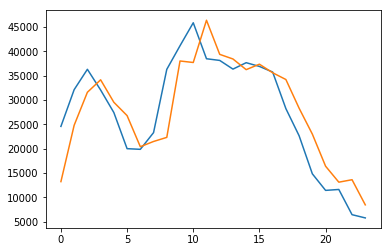

In [20]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-predict_values_exp:])
pyplot.plot(predictions)
pyplot.show()